In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [3]:
data=pd.read_csv("train.tsv",sep="\t")

In [4]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
data.shape

(1482535, 8)

In [8]:
data=data.loc[0:10000,]

In [9]:
data.shape

(10001, 8)

In [12]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [15]:
train.shape, test.shape


((8024, 8), (1977, 8))

In [16]:
train.head()


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8024 entries, 0 to 10000
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   train_id           8024 non-null   int64  
 1   name               8024 non-null   object 
 2   item_condition_id  8024 non-null   int64  
 3   category_name      7987 non-null   object 
 4   brand_name         4617 non-null   object 
 5   price              8024 non-null   float64
 6   shipping           8024 non-null   int64  
 7   item_description   8024 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 564.2+ KB


In [18]:
train.price.describe()

count    8024.000000
mean       26.472458
std        40.416187
min         0.000000
25%        10.000000
50%        16.000000
75%        29.000000
max      1506.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

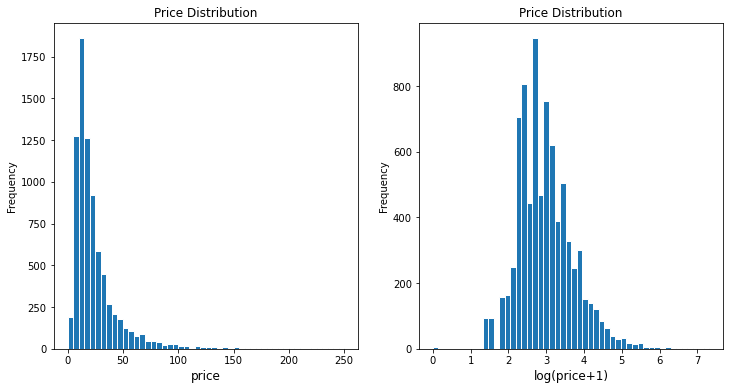

In [19]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

- The price of items are left skewed, vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

In [20]:
train['shipping'].value_counts() / len(train)


0    0.545239
1    0.454761
Name: shipping, dtype: float64

- Over 55% of items shipping fee were paid by the buyers. How shipping related to price?

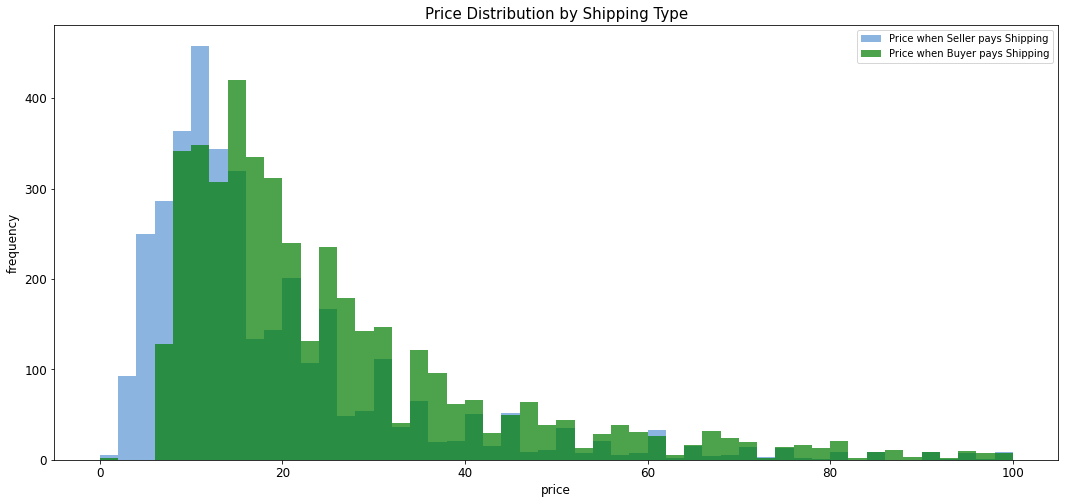

In [22]:
shipping_fee_by_buyer = train.loc[data['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[data['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [23]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.34 if seller pays shipping
The average price is 29.92 if buyer pays shipping


- We compare again after log-transformation on the price.

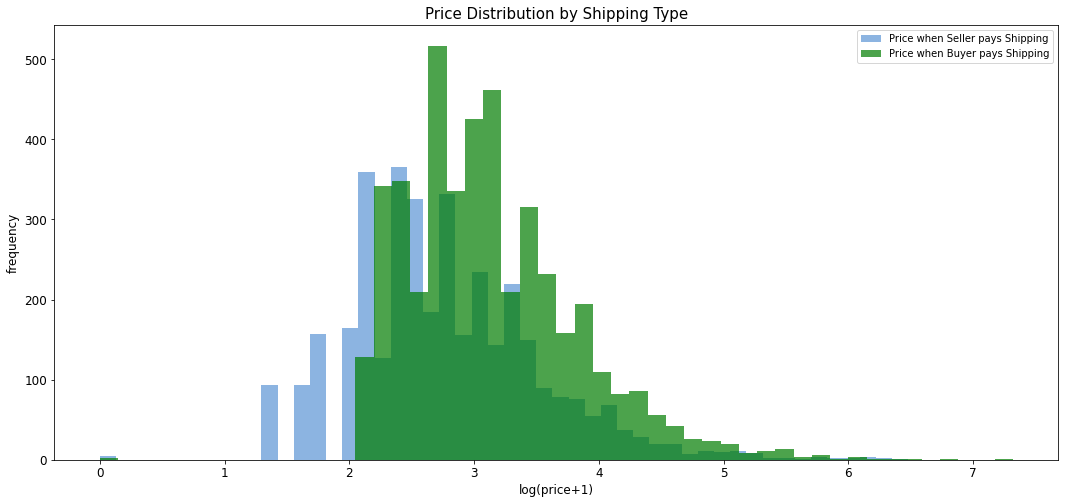

In [24]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

- It is obvious that the average price is higher when buyer pays shipping.

## Category names

In [25]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 593 unique values in category name column


- top 10 most common category names

In [26]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 325
Women/Tops & Blouses/T-Shirts                                  239
Beauty/Makeup/Face                                             205
Beauty/Makeup/Lips                                             177
Beauty/Makeup/Eyes                                             144
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    139
Electronics/Video Games & Consoles/Games                       129
Women/Tops & Blouses/Blouse                                    121
Women/Underwear/Bras                                           120
Beauty/Fragrance/Women                                         110
Name: category_name, dtype: int64

## Item condition vs. Price

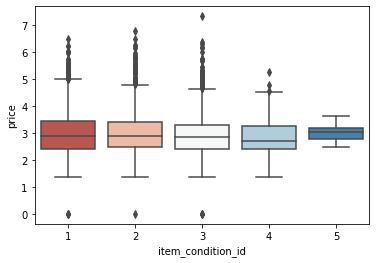

In [27]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))


# model

In [28]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 37 items that do not have a category name.


In [29]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())


There are 3407 items that do not have a brand name.


In [30]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())


There are 0 items that do not have a description.


In [31]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [32]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [33]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [36]:
train = train[train.price != 0].reset_index(drop=True)


In [37]:
train


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
4,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
...,...,...,...,...,...,...,...,...
8012,9996,NWT Wildfox Fringe Top XS Coachella,1,Women/Tops & Blouses/T-Shirts,Wildfox Couture,17.0,0,NWT Wildfox Coachella Fringe Top size XS. Mint...
8013,9997,Like New Baby Carrier,2,Kids/Gear/Backpacks & Carriers,Chicco,15.0,1,Excellent condition. No tears no stains used m...
8014,9998,Minecraft Creeper Scarf,1,Kids/Boys (4+)/Accessories,NaN,12.0,1,"A scarf is a trusty companion, covering your n..."
8015,9999,Michael Kors Swim Top,2,Women/Swimwear/One-Piece,Michael Kors,11.0,0,MICHAEL Michael Kors Halter Logo Tankini Top t...


In [39]:
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

In [40]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [42]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [43]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [44]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [45]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [46]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [47]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [58]:
X_dummies = pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True)


In [55]:
X_dummies.dtypes

shipping                          int64
item_condition_id_1    Sparse[uint8, 0]
item_condition_id_2    Sparse[uint8, 0]
item_condition_id_3    Sparse[uint8, 0]
item_condition_id_4    Sparse[uint8, 0]
item_condition_id_5    Sparse[uint8, 0]
dtype: object

In [57]:
sparse_merge = hstack(( X_description, X_brand, X_category, X_name)).tocsr()


In [59]:
sparse_merge.shape


(9994, 52186)

Remove features with document frequency <=1.

In [60]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [61]:
sparse_merge.shape


(9994, 31647)

In [62]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [64]:
model=tree.DecisionTree.train(train)

<8017x31647 sparse matrix of type '<class 'numpy.float64'>'
	with 244750 stored elements in Compressed Sparse Row format>

Note: you may need to restart the kernel to use updated packages.


'C:\Users\NAGENDRA' is not recognized as an internal or external command,
operable program or batch file.
